# MMI-based NIR/MIR demultiplexer

Note: the cost of running the FDTD portion of the notebook is larger than 10 FlexCredits. The cost of running the EME portion is minimal.

This notebook introduces an MMI-based beam splitter demultiplexer designed for the NIR/MIR wavelengths. The device separates the two wavelengths, with 2 μm forming a direct image at the bar port, and 1.55 μm forming a mirrored image at the cross port. This separation is achieved by optimizing the MMI length. The eigenmode expansion method (EME) is very efficient for designing large MMI components because it doesn't require meshing the multimode region. Even though `Tidy3D`'s FDTD solver is ultrafast, using EME can be advantageous in some situations. For example, when you are interested in just a few wavelengths, simulating very long waveguide structures using EME can be much faster than FDTD.

In this example, we first demonstrate the optimization of MMI length using the EME solver, which is low-cost and very time-efficient. Once the optimum MMI length is found, we further use FDTD to verify the design performance. This combined approach of EME and FDTD allows for efficient and accurate photonic component design optimization.

The design used in this notebook is based on `M-Said Rouifed, Callum G. Littlejohns, Guo X. Tina, Haodong Qiu, Jordi Soler Penades, Milos Nedeljkovic, Zecen Zhang, Chongyong Liu, David J. Thomson, Goran Z. Mashanovich, Graham T. Reed, and Hong Wang, "Ultra-compact MMI-based beam splitter demultiplexer for the NIR/MIR wavelengths of 1.55 μm and 2 μm," Opt. Express 25, 10893-10900 (2017)` [DOI: 10.1364/OE.25.010893](https://doi.org/10.1364/OE.25.010893).

<img src="img/mmi_mux.png" width="500" alt="Schematic of the MMI demultiplexer">

For a more detailed demonstration of the EME solver, please refer to the dedicated [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/EMESolver/).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
import tidy3d.web as web

## EME Simulations to Find the Optimal MMI Length

The operating principle of the MMI structure relies on the self-image effect. This effect involves exciting multiple guided modes in a multimode waveguide region to create constructive interference, forming one or more images of the original optical mode. These images appear at set intervals along the propagation path. However, when the modal excitations are restricted, only certain modes are activated. This results in either a direct or mirrored image of the original optical mode. To achieve this restricted interference, the input/output of a 1x2 MMI coupler should be placed at ±$s=w_{mmi}/6$ from the center of the multimode region, where $w_{mmi}$ is the width of the multimode region (see the [reference](https://doi.org/10.1364/OE.25.010893) for more details). 

The length of the multimode region, $l_{mmi}$, can be optimized so that at a specific target wavelength, the direct image appears at one port, while at a different wavelength, the mirrored image appears at another port. This design allows the device to function as a wavelength demultiplexer, separating light based on wavelength. Here we set up an [EMESimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMESimulation.html) and utilize [EMELengthSweep](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMELengthSweep.html) to optimize $w_{mmi}$.

First, set up the basic simulation parameters. The two target wavelengths are 1.55 μm and 2 μm. The width of the multimode region is set to 6 μm. Both input and output waveguides are 1.3 μm in width. The design is based on silicon rib waveguide. The silicon layer thickness is 340 nm and the partial etch depth is 240 nm.  

In [2]:
lda0 = 1.55  # first target wavelength
lda1 = 2.0  # second target wavelength
freq0 = td.C_0 / lda0  # first target frequency
freq1 = td.C_0 / lda1  # second target frequency

w_mmi = 6  # width of the mmi
w_in = 1.3  # width of the input waveguide
w_out = 1.3  # width of the output waveguides
d = 0.24  # rib thickness
t = 0.1  # slab thickness
s = w_mmi * (1 / 6)  # lateral offset
l_mmi_0 = 300  # initial length of the mmi
inf_eff = 1e4  # effective infinity

buffer_x = 5  # buffer spacing in x
buffer_y = 1  # buffer spacing in y

We directly use the silicon and silicon oxide materials from the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) for convenience.

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

Next we define a function `make_mmi_structures(l_mmi)` that creates the MMI structures based on the length of the multimode region.

In [4]:
def make_mmi_structures(l_mmi):
    # define the silicon slab
    slab = td.Structure(
        geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, t)),
        medium=si,
    )

    # define the input waveguide
    wg_in = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, s - w_in / 2, t), rmax=(0, s + w_in / 2, t + d)
        ),
        medium=si,
    )

    # define the mmi region
    mmi = td.Structure(
        geometry=td.Box.from_bounds(rmin=(0, -w_mmi / 2, t), rmax=(l_mmi, w_mmi / 2, t + d)),
        medium=si,
    )

    # define the top output waveguide
    wg_out_top = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(l_mmi, s - w_in / 2, t), rmax=(inf_eff, s + w_in / 2, t + d)
        ),
        medium=si,
    )

    # define the bottom output waveguide
    wg_out_bottom = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(l_mmi, -s - w_in / 2, t), rmax=(inf_eff, -s + w_in / 2, t + d)
        ),
        medium=si,
    )

    return [slab, wg_in, mmi, wg_out_top, wg_out_bottom]

The direct result from an EME simulation is the S parameters expressed in the modal basis. In the 1x2 MMI case, the mode at the output waveguides are the supermodes. In practice, we would like to know the fundamental mode transmission at each waveguide individually. This requires performing a change of basis. To do so, we need to obtain the fundamental mode profile at each output waveguide, which can be done by defining a [ModeSolverMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSolverMonitor.html) at each waveguide.

In [5]:
# define a mode solver monitor at the top output waveguide
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_monitor_top = td.ModeSolverMonitor(
    name="top",
    size=(0, 2 * w_in, td.inf),
    center=(l_mmi_0 + buffer_x / 2, s, t),
    freqs=[freq0, freq1],
    mode_spec=mode_spec,
)

# define a mode solver monitor at the bottom output waveguide
mode_monitor_bottom = td.ModeSolverMonitor(
    name="bottom",
    size=(0, 2 * w_in, td.inf),
    center=(l_mmi_0 + buffer_x / 2, -s, t),
    freqs=[freq0, freq1],
    mode_spec=mode_spec,
)

For an EME simulation, we need to define two sets of grid specifications, one for mode solving and the other for EME propagation. For mode solving, we will use an automatic nonuniform grid with 15 steps per wavelength. For the EME grid, we will use [EMEExplicitGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMEExplicitGrid.html) since we only need to place a grid boundary where the structure changes, i.e. the interfaces between the waveguides and the multimode region. We also need to specify the number of modes to be used in EME. The number of modes needs to be sufficiently large for the EME simulation to be accurate.

When doing an EME simulation, we can easily perform a length sweep by specifying the `sweep_spec`. In this case, we will sweep the multimode region length from 251 μm to 350 μm in 100 simulations. The eigenmodes only need to be solved once for the entire length sweep so the simulation time will be very short.

In [6]:
# define the yee cell grid spec
grid_spec = td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0)

# define eme grid spec
eme_grid_spec = td.EMEExplicitGrid(
    boundaries=[0, l_mmi_0],
    mode_specs=[
        td.EMEModeSpec(num_modes=6),
        td.EMEModeSpec(num_modes=10),
        td.EMEModeSpec(num_modes=6),
    ],
)

l_mmi_list = np.linspace(251, 350, 100)  # range of the mmi length to simulate

# define eme simulation
eme_sim = td.EMESimulation(
    center=(l_mmi_0 / 2, 0, t + d / 2),
    size=(l_mmi_0 + 2 * buffer_x, w_mmi + 2 * buffer_y, 7 * (d + t)),
    structures=make_mmi_structures(l_mmi_0),
    monitors=[mode_monitor_top, mode_monitor_bottom],
    grid_spec=grid_spec,
    eme_grid_spec=eme_grid_spec,
    freqs=[freq0, freq1],
    axis=0,
    medium=sio2,
    port_offsets=(buffer_x / 2, buffer_x / 2),
    sweep_spec=td.EMELengthSweep(scale_factors=list(l_mmi_list / l_mmi_0)),
)

Before running the simulation, visualize the simulation to verify the setup is correct.

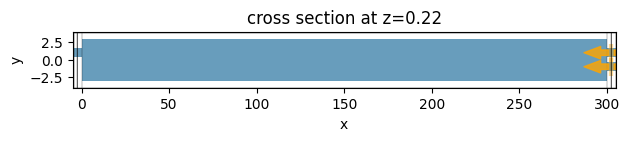

In [7]:
ax = eme_sim.plot(z=t + d / 2)
ax.set_aspect(4)

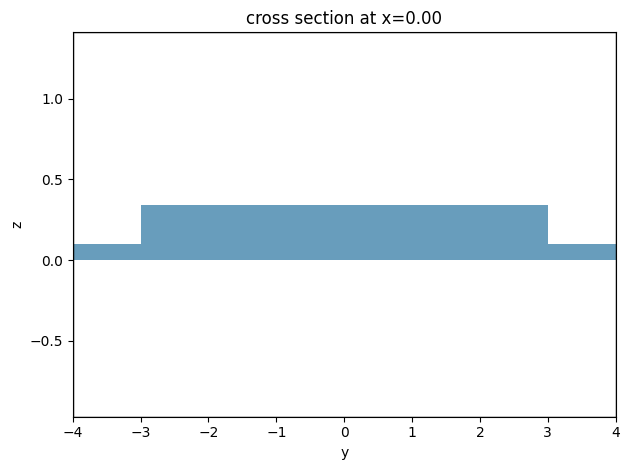

In [8]:
ax = eme_sim.plot(x=0)
ax.set_aspect("auto")

Now we can submit the simulation to the server.

In [9]:
eme_sim_data = web.run(eme_sim, task_name="MMI_EME")

09:08:47 Eastern Daylight Time Created task 'MMI_EME' with task_id              
                               'eme-dfc82b27-4c9d-499f-ac9f-810e425c31ce' and   
                               task_type 'EME'.

                               Tidy3D's EME solver is currently in the beta     
                               stage. Cost of EME simulations is subject to     
                               change in the future.

Output()

09:08:48 Eastern Daylight Time status = success

Output()

09:08:51 Eastern Daylight Time loading simulation from simulation_data.hdf5

After the EME simulation is complete, we first visualize the mode profile at the output waveguide. As expected, we see the fundamental mode.

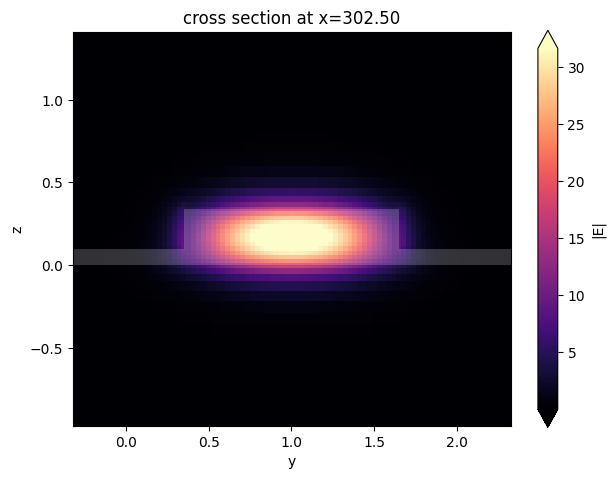

In [10]:
eme_sim_data.plot_field("top", "E", "abs", f=freq0)
plt.show()

With this, we can calculate the transmission of the fundamental mode at both output waveguides by using [smatrix_in_basis](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMESimulationData.html#tidy3d.EMESimulationData.smatrix_in_basis). First, calculate and plot the transmission at 1.55 μm. Around 290 μm, we see a high transmission to the bottom waveguide and a low transmission to the top waveguide.

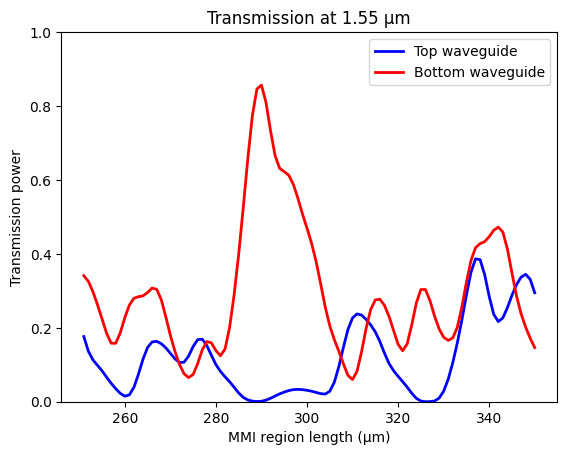

In [11]:
T_top_freq0 = (
    eme_sim_data.smatrix_in_basis(modes2=eme_sim_data["top"])
    .S21.sel(f=freq0, mode_index_in=0)
    .squeeze(drop=True)
    .abs
    ** 2
)
T_bottom_freq0 = (
    eme_sim_data.smatrix_in_basis(modes2=eme_sim_data["bottom"])
    .S21.sel(f=freq0, mode_index_in=0)
    .squeeze(drop=True)
    .abs
    ** 2
)

plt.plot(l_mmi_list, T_top_freq0, c="blue", linewidth=2, label="Top waveguide")
plt.plot(l_mmi_list, T_bottom_freq0, c="red", linewidth=2, label="Bottom waveguide")
plt.title(f"Transmission at {lda0} μm")
plt.ylim(0, 1)
plt.xlabel("MMI region length (μm)")
plt.ylabel("Transmission power")
plt.legend()
plt.show()

Similarly, calculate and plot the transmission at 2 μm. Around 290 μm we see a high transmission to the top waveguide and low transmission to the bottom waveguide.

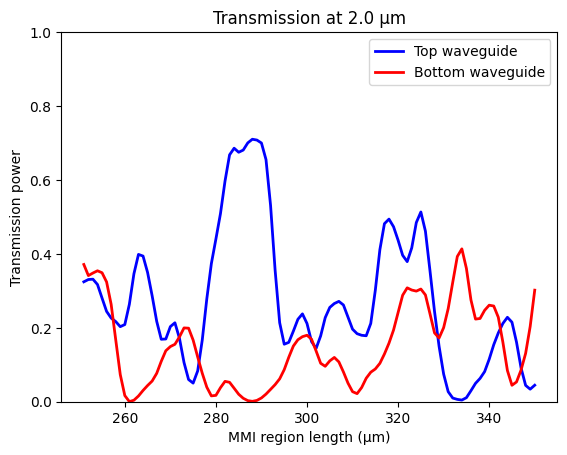

In [12]:
T_top_freq1 = (
    eme_sim_data.smatrix_in_basis(modes2=eme_sim_data["top"])
    .S21.sel(f=freq1, mode_index_in=0)
    .squeeze(drop=True)
    .abs
    ** 2
)
T_bottom_freq1 = (
    eme_sim_data.smatrix_in_basis(modes2=eme_sim_data["bottom"])
    .S21.sel(f=freq1, mode_index_in=0)
    .squeeze(drop=True)
    .abs
    ** 2
)

plt.plot(l_mmi_list, T_top_freq1, c="blue", linewidth=2, label="Top waveguide")
plt.plot(l_mmi_list, T_bottom_freq1, c="red", linewidth=2, label="Bottom waveguide")
plt.title(f"Transmission at {lda1} μm")
plt.ylim(0, 1)
plt.xlabel("MMI region length (μm)")
plt.ylabel("Transmission power")
plt.legend()
plt.show()

To find the optimal design, we will use two metrics, the contrast and the insertion loss. Now we calculate and plot the contrasts at 1.55 μm and 2 μm.

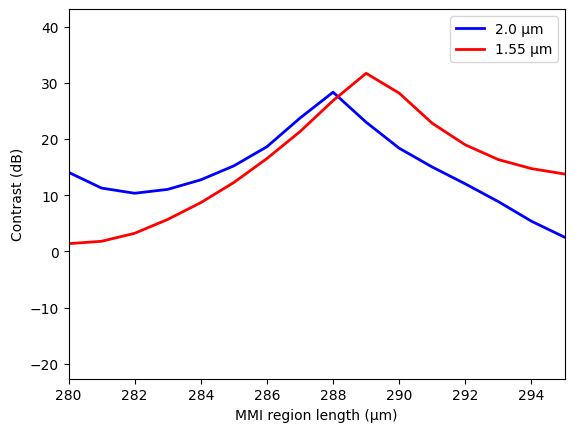

In [13]:
plt.plot(
    l_mmi_list,
    10 * np.log10(T_top_freq1 / T_bottom_freq1),
    c="blue",
    linewidth=2,
    label=f"{lda1} μm",
)
plt.plot(
    l_mmi_list,
    10 * np.log10(T_bottom_freq0 / T_top_freq0),
    c="red",
    linewidth=2,
    label=f"{lda0} μm",
)
plt.xlim(280, 295)
plt.xlabel("MMI region length (μm)")
plt.ylabel("Contrast (dB)")
plt.legend()
plt.show()

Next, calculate and plot the insertion loss at 1.55 μm and 2 μm. 

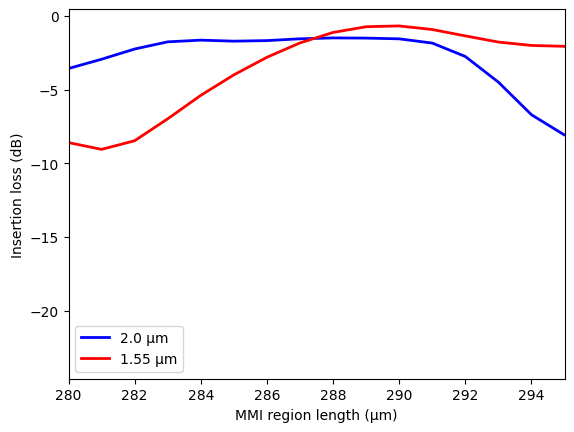

In [14]:
plt.plot(l_mmi_list, 10 * np.log10(T_top_freq1), c="blue", linewidth=2, label=f"{lda1} μm")
plt.plot(l_mmi_list, 10 * np.log10(T_bottom_freq0), c="red", linewidth=2, label=f"{lda0} μm")
plt.xlim(280, 295)
plt.xlabel("MMI region length (μm)")
plt.ylabel("Insertion loss (dB)")
plt.legend()
plt.show()

We want to have a high contrast and low insertion loss at the same time. The optimal $l_{mmi}$ appears to be around 287-290 μm. 

## FDTD Simulation of the Optimal Design

Now that we have used EME to narrow down the optimal range of $l_{mmi}$, the next step would be to verify and fine-tune the design using full-wave FDTD. One can perform a parameter sweep of $l_{mmi}$ to identify the best value. For simplicity, here we only examine the case where $l_{mmi}$=287 μm.

EME is a frequency-domain method. In order to obtain a spectrum, one needs to sweep the frequency. FDTD on the other hand is a time-domain method. A wide spectral response can be obtained in one single simulation. In the FDTD simulation, we will calculate the transmission from 1.4 μm to 2.2 μm.

We will define [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to excite the input waveguide with the fundamental mode. [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) will be used to measure the transmission of the fundamental mode. For visualization of the self imaging, we also use [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to record the field at 1.55 μm and 2 μm. To reduce the data size, we downsample the field monitor data by a factor of 3 in the $x$ and $y$ directions by setting `interval_space=(3, 3, 1)`.

In [15]:
l_mmi_opt = 287  # optimal multimode region length
ldas = np.linspace(1.4, 2.2, 201)  # wavelength range of interest
freqs = td.C_0 / ldas  # frequency range of interest

# define a mode source as excitation
mode_source = td.ModeSource(
    center=(-buffer_x / 2, s, t),
    size=(0, 2 * w_in, td.inf),
    source_time=td.GaussianPulse(freq0=(freq0 + freq1) / 2, fwidth=0.5 * (freq0 - freq1)),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# define a mode monitor at the top output waveguide
mode_monitor_top = td.ModeMonitor(
    name="top",
    size=(0, 2 * w_in, td.inf),
    center=(l_mmi_opt + buffer_x / 2, s, t),
    freqs=freqs,
    mode_spec=mode_spec,
)

# define a mode monitor at the bottom output waveguide
mode_monitor_bottom = td.ModeMonitor(
    name="bottom",
    size=(0, 2 * w_in, td.inf),
    center=(l_mmi_opt + buffer_x / 2, -s, t),
    freqs=freqs,
    mode_spec=mode_spec,
)

# define a field monitor (with downsampling) to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, t + d / 2),
    size=(td.inf, td.inf, 0),
    interval_space=(3, 3, 1),
    freqs=[freq0, freq1],
    name="field",
)

Finally, define the FDTD simulation. 

Since the MMI is long, we need a substantial `run_time` to ensure convergence. Here we use 25 ps. 

Both silicon and silicon oxide are dispersive materials and they extend into the simulation boundaries. In this case, using PML could cause the simulation to diverge. To eliminate this concern, we use the [absorber](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Absorber.html) boundary condition. The default number of absorber layers is 40. To further minimize reflection, we use 60 layers in the $+x$ direction.

In [16]:
run_time = 2.5e-11  # simulation run time

# construct simulation
fdtd_sim = td.Simulation(
    center=(l_mmi_opt / 2, 0, t + d / 2),
    size=(l_mmi_opt + 2 * buffer_x, w_mmi + 2 * buffer_y, 7 * (d + t)),
    grid_spec=grid_spec,
    structures=make_mmi_structures(l_mmi_opt),
    sources=[mode_source],
    monitors=[mode_monitor_top, mode_monitor_bottom, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber()),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),
    ),
    medium=sio2,
)

Verify the simulation setup by plotting it.

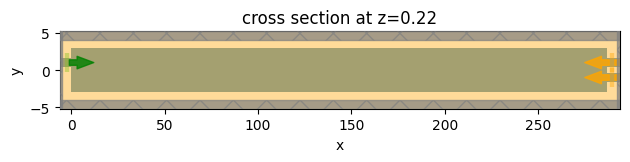

In [17]:
ax = fdtd_sim.plot(z=t + d / 2)
ax.set_aspect(4)

Before running large FDTD simulations, it is always recommended to check the estimated cost first. This task is estimated to cost over 60 credits.

In [18]:
job = web.Job(simulation=fdtd_sim, task_name="MMI_FDTD", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)

09:09:12 Eastern Daylight Time Created task 'MMI_FDTD' with task_id             
                               'fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=696060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=58306;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f\taskId]8;;\
                               ]8;id=696060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f\=]8;;\]8;id=426368;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f\fdve]8;;\]8;id=696060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f\-dd6dbd96-3a9c-4699-a9b7-6c3dbcda2c8f']8;;\.

Output()

09:09:14 Eastern Daylight Time Maximum FlexCredit cost: 67.660. Minimum cost    
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

Submit the simulation to the server.

In [19]:
sim_data = job.run(path="data/simulation_data.hdf5")

09:09:15 Eastern Daylight Time status = success

Output()

09:09:18 Eastern Daylight Time loading simulation from data/simulation_data.hdf5

After the simulation is complete, we can visualize the field intensity distributions at 1.55 μm and 2 μm.

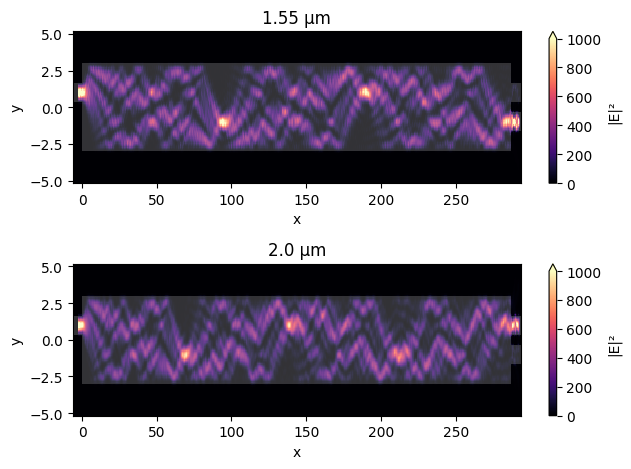

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True)
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax1, vmin=0, vmax=1e3
)
ax1.set_aspect("auto")
ax1.set_title(f"{lda0} μm")

sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq1, ax=ax2, vmin=0, vmax=1e3
)
ax2.set_aspect("auto")
ax2.set_title(f"{lda1} μm")
plt.show()

More importantly, we want to see the transmission spectra at the two output waveguides to verify the wavelength demultiplexing performance.

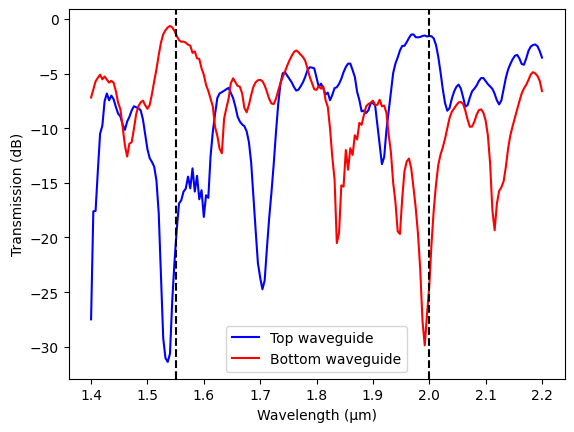

In [21]:
# extract the transmission data from the mode monitor
amp_top = sim_data["top"].amps.sel(mode_index=0, direction="+")
T_top = np.abs(amp_top) ** 2  # transmission to the top waveguide
amp_bottom = sim_data["bottom"].amps.sel(mode_index=0, direction="+")
T_bottom = np.abs(amp_bottom) ** 2  # transmission to the top waveguide

plt.plot(ldas, 10 * np.log10(T_top), c="blue", label="Top waveguide")
plt.plot(ldas, 10 * np.log10(T_bottom), c="red", label="Bottom waveguide")
plt.axvline(x=lda0, c="black", linestyle="--")
plt.axvline(x=lda1, c="black", linestyle="--")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.show()

The result indicates a high contrast (~20 dB) and low insertion loss (<2 dB) at the two target wavelengths, verifying the EME result. 